# Setup

In [3]:
# imports 
import pandas as pd
import opendatasets as od
import time
import datetime
import torch.nn as nn
from torchsummary import summary
import torch
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from matplotlib.pyplot import xticks

In [4]:
dataset_url = 'https://www.kaggle.com/competitions/new-york-city-taxi-fare-prediction'
# od.download(dataset_url)

In [5]:
df = pd.read_csv('./NYCTaxiFares_small.csv')
df['pickup_datetime'].max()

'2010-04-25 03:59:42 UTC'

# Pre-processing

In [6]:
df.drop(labels=['fare_class'], axis=1, inplace=True)

In [7]:
## Running this cell is really fucking slow, but it works.
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

def havardsine_distance(lat1, long1, lat2, long2):
    r = 6371

    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)

    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(long2 - long1)
    a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    d = (r * c) # convert to kilometer
    return d

df['dist_km'] = df.apply(lambda row: havardsine_distance(row.pickup_latitude, row.pickup_longitude, row.dropoff_latitude, row.dropoff_longitude), axis=1)

airport_cords = [
    [40.691547, -74.180202], # NEWARK
    [40.773281, -73.869845], # LAGUARDIA
]

# When I wrote this code, only God and I knew what was going on. Today, only God knows.
def close_to_airport(values):
    pickup_latitude = values['pickup_latitude']
    pickup_longitude = values['pickup_longitude']
    dropoff_latitude = values['dropoff_latitude']
    dropoff_longitude = values['dropoff_longitude']

    # JFK is special, it needs a bigger radius
    jfkpickup = havardsine_distance(pickup_latitude, pickup_longitude, 40.645042, -73.786928) <= 1.00
    jfkdropoff = havardsine_distance(dropoff_latitude, dropoff_longitude, 40.645042, -73.786928) <= 1.00

    # Newark is a small airport but their parking log is BIG.
    newarkpickup = havardsine_distance(pickup_latitude, pickup_longitude, 40.691547, -74.180202) <= 1.00
    newarkdropoff = havardsine_distance(dropoff_latitude, dropoff_longitude, 40.691547, -74.180202) <= 1.00

    # Third largest, it's an abstract airport with a stretched out U shaped parking place
    # LaGuardia
    laguardiapickup = havardsine_distance(pickup_latitude, pickup_longitude, 40.773855, -73.871712) <= 0.50
    laguardiadropoff = havardsine_distance(dropoff_latitude, dropoff_longitude, 40.773855, -73.871712) <= 0.50

    return 1 if jfkpickup or jfkdropoff or newarkpickup or newarkdropoff or laguardiapickup or laguardiadropoff else 0

df['is_by_airport'] = df.apply(close_to_airport, axis=1)

In [8]:
my_time = df['pickup_datetime'][0]

In [9]:
df['EDTdate'] = df['pickup_datetime'] - pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour'] < 12, 0, 1)

In [10]:
df['Weekday'] = pd.to_numeric(df['EDTdate'].dt.strftime("%w")) # an int between 0 - 6, representing the weekdays
df['Month'] = pd.to_numeric(df['EDTdate'].dt.strftime("%m")) # an int between 0 - 6, representing the weekdays

#Formatting this correctly, we can use the dates to get the historical weather data for the dates
df['FullDate'] = df['EDTdate'].dt.strftime('%x')
#print(df['FullDate'].min())
#print(df['FullDate'].max())
print(df['FullDate'].unique())

['04/19/10' '04/17/10' '04/11/10' '04/16/10' '04/22/10' '04/23/10'
 '04/15/10' '04/20/10' '04/21/10' '04/14/10' '04/13/10' '04/12/10'
 '04/24/10' '04/18/10']


In [11]:
# lets have some weather-y fuuuuuuuuuuuun-fuuuuuun-function
# see this for doc https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/GHCND_documentation.pdf
weather_data = pd.read_csv('nyc-weather-data.csv')
weather_labels = ['SNWD', 'SNOW', 'AWND'] #snow depth, snowfall, wind speed
for index, item in enumerate(weather_labels):
    weather_data.loc[weather_data[item] <= -9999, item] = 0 # -9999 means that there is no data

# df['dist_km'] = df.apply(lambda row: havardsine_distance(row.pickup_latitude, row.pickup_longitude, row.dropoff_latitude, row.dropoff_longitude), axis=1)

weather_data['DATE'] = weather_data.apply(lambda row: datetime.datetime.strptime(str(row.DATE), '%Y%m%d').strftime('%m/%d/%y'), axis=1)
weather_data = weather_data[['DATE','PRCP','SNWD','SNOW','TMAX','TMIN','AWND']]

weather_data['TMIN'] = (weather_data['TMIN'] / 10) # the API returns degrees in an old format. We therefore convert the value to a tenth of its own form. Check the docu for this.
weather_data['TMAX'] = (weather_data['TMAX'] / 10) # min temperature and max temperateure
weather_data['PRCP'] = weather_data['PRCP'] / 10   # precipitation

weather_data['AWND'] = weather_data['AWND'] / 2.237 # meters per second

df.rename(columns={'FullDate':'DATE'}, inplace=True)

merged_df = pd.merge(df, weather_data, how="left",on="DATE")

In [12]:
# network_data = merged_df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'dist_km', 'passenger_count', 'Hour', 'AMorPM', 'Weekday', 'Month', 'fare_amount']]#, 'is_by_airport','PRCP', 'SNWD', 'SNOW', 'TMAX', 'TMIN', 'AWND']]
#
# #print(network_data)
#
# prediction = network_data['fare_amount']
#
# # network_data.drop('fare_amount', axis=1)
# X = network_data.drop('fare_amount', axis=1)
#
# #y = prediction.values.reshape(-1,1)
# y=prediction
#
# # scaler = StandardScaler()
# #
# # scaler.fit_transform(train_X, test_X)

In [13]:
merged_df

,pickup_datetime,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,is_by_airport,EDTdate,...,AMorPM,Weekday,Month,DATE,PRCP,SNWD,SNOW,TMAX,TMIN,AWND
0,2010-04-19 08:17:56+00:00,6.5,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,0,2010-04-19 04:17:56+00:00,...,0,1,4,04/19/10,0.0,0,0,17.2,7.8,13.857845
1,2010-04-17 15:43:53+00:00,6.9,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,0,2010-04-17 11:43:53+00:00,...,0,6,4,04/17/10,0.3,0,0,12.2,7.8,13.410818
2,2010-04-17 11:23:26+00:00,10.1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,0,2010-04-17 07:23:26+00:00,...,0,6,4,04/17/10,0.3,0,0,12.2,7.8,13.410818
3,2010-04-11 21:25:03+00:00,8.9,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,0,2010-04-11 17:25:03+00:00,...,1,0,4,04/11/10,0.0,0,0,24.4,11.1,13.410818
4,2010-04-17 02:19:01+00:00,19.7,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,0,2010-04-16 22:19:01+00:00,...,1,5,4,04/16/10,7.9,0,0,13.9,7.8,14.751900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,2010-04-18 14:33:03+00:00,15.3,-73.955857,40.784590,-73.981941,40.736789,1,5.751348,0,2010-04-18 10:33:03+00:00,...,0,0,4,04/18/10,0.0,0,0,13.9,5.6,14.304873
119996,2010-04-23 10:27:48+00:00,15.3,-73.996329,40.772727,-74.049890,40.740413,1,5.767444,0,2010-04-23 06:27:48+00:00,...,0,5,4,04/23/10,0.0,0,0,20.0,6.7,12.963791
119997,2010-04-18 18:50:40+00:00,12.5,-73.988574,40.749772,-74.011541,40.707799,3,5.052523,0,2010-04-18 14:50:40+00:00,...,1,0,4,04/18/10,0.0,0,0,13.9,5.6,14.304873
119998,2010-04-13 08:14:44+00:00,4.9,-74.004449,40.724529,-73.992697,40.730765,1,1.208923,0,2010-04-13 04:14:44+00:00,...,0,2,4,04/13/10,0.0,0,0,13.3,8.3,9.834600


# EDA

In [14]:
merged_df.dtypes

pickup_datetime      datetime64[ns, UTC]
fare_amount                      float64
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dist_km                          float64
is_by_airport                      int64
EDTdate              datetime64[ns, UTC]
Hour                               int64
AMorPM                             int64
Weekday                            int64
Month                              int64
DATE                              object
PRCP                             float64
SNWD                               int64
SNOW                               int64
TMAX                             float64
TMIN                             float64
AWND                             float64
dtype: object

In [15]:
merged_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,is_by_airport,Hour,AMorPM,Weekday,Month,PRCP,SNWD,SNOW,TMAX,TMIN,AWND
count,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.0,120000.000000,120000.0,120000.0,120000.000000,120000.000000,120000.000000
mean,10.040326,-73.976626,40.751443,-73.974501,40.751695,1.347167,3.322160,0.032442,11.920042,0.531642,3.207108,4.0,0.741308,0.0,0.0,18.541002,8.677797,12.350287
std,7.500134,0.031497,0.025821,0.032419,0.030279,0.759263,3.337004,0.177171,5.964038,0.499000,1.950742,0.0,2.171493,0.0,0.0,3.708399,1.745160,1.649492
min,2.500000,-74.465447,40.121653,-74.443323,40.164927,1.000000,0.010208,0.000000,0.000000,0.000000,0.000000,4.0,0.000000,0.0,0.0,12.200000,5.600000,9.834600
25%,5.700000,-73.992386,40.736594,-73.991478,40.735914,1.000000,1.316428,0.000000,7.000000,0.000000,2.000000,4.0,0.000000,0.0,0.0,13.900000,7.800000,10.728654
50%,7.700000,-73.982084,40.753661,-73.980411,40.754441,1.000000,2.237084,0.000000,12.000000,1.000000,3.000000,4.0,0.000000,0.0,0.0,20.000000,7.800000,12.963791
75%,11.300000,-73.968710,40.768020,-73.965500,40.768880,1.000000,4.034564,0.000000,17.000000,1.000000,5.000000,4.0,0.000000,0.0,0.0,21.100000,10.600000,13.410818
max,49.900000,-73.311845,40.981292,-73.496140,40.993498,5.000000,28.846365,1.000000,23.000000,1.000000,6.000000,4.0,7.900000,0.0,0.0,24.400000,11.700000,14.751900


Text(0.5, 0, 'Distance (km)')

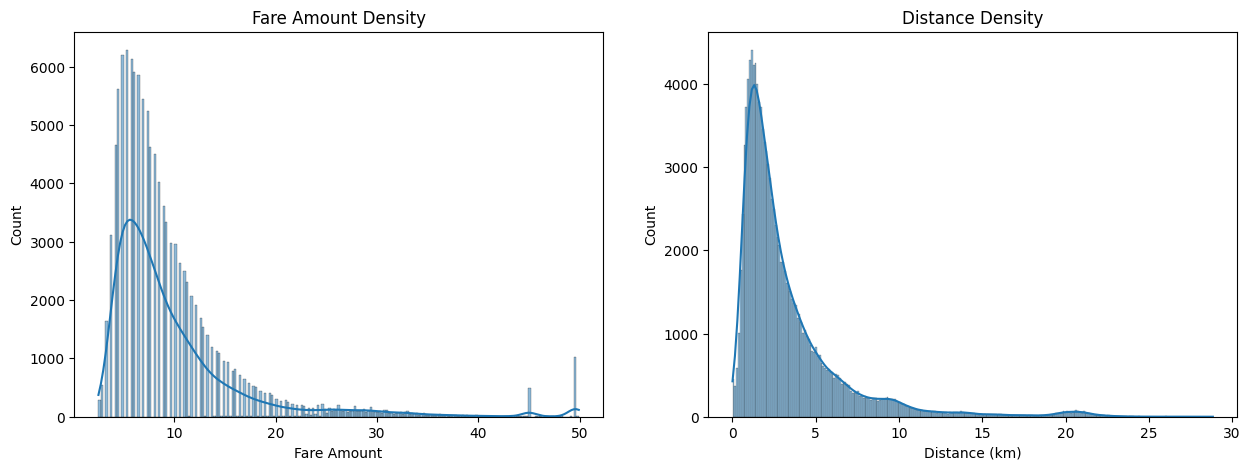

In [16]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))

sns.histplot(merged_df['fare_amount'], ax=axs[0], kde=True)
axs[0].set_title("Fare Amount Density")
axs[0].set_xlabel("Fare Amount")

sns.histplot(merged_df['dist_km'], ax=axs[1], kde=True)
axs[1].set_title("Distance Density")
axs[1].set_xlabel("Distance (km)")

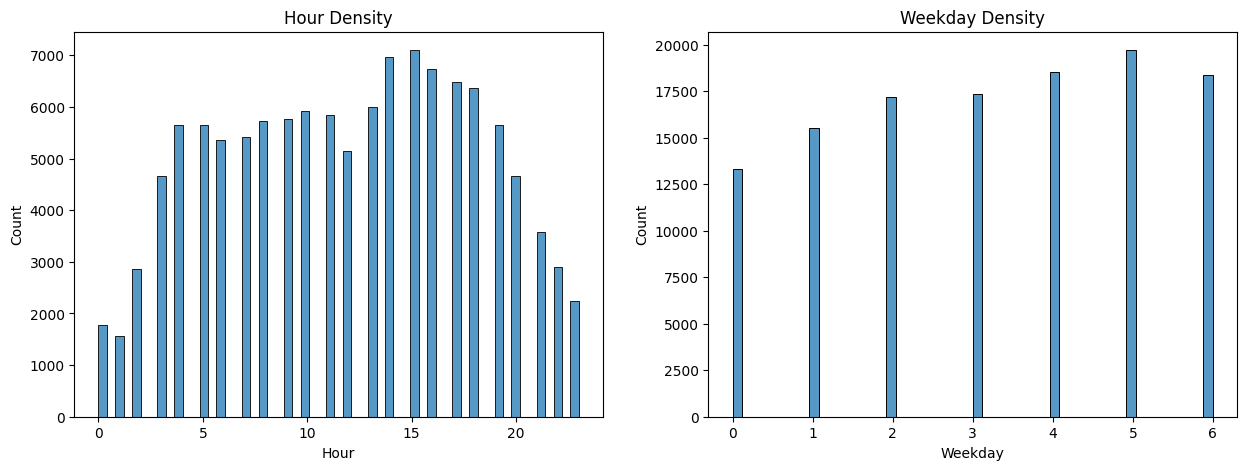

In [17]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))

sns.histplot(merged_df, x='Hour', ax=axs[0])
axs[0].set_title('Hour Density')
axs[0].set_xlabel('Hour')

sns.histplot(merged_df, x='Weekday', ax=axs[1])
axs[1].set_title('Weekday Density')
axs[1].set_xlabel('Weekday')

plt.show()

In [18]:
"""
PRCP - Precipitation
SNOW - Snowfall - All 0?
SNWD - Snow depth - All 0?
TMAX - Max temperature
TMIN - Min temperature
AWND - Average wind speed
"""
# fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20,20))

# sns.histplot(merged_df['SNOW'], ax=axs[0][0])
# axs[0][0].set_title("SNOW distribution")
# axs[0][0].set_xlabel("SNOW")

# sns.histplot(merged_df['SNWD'], ax=axs[0][1])
# axs[0][1].set_title("SNWD distribution")
# axs[0][1].set_xlabel("SNWD")

# sns.histplot(merged_df['PRCP'], ax=axs[1][0])
# axs[1][0].set_title("PRCP")
# axs[1][0].set_xlabel("PRCP")

# sns.histplot(merged_df["AWND"], ax=axs[1][1])
# axs[1][1].set_title("AWND")
# axs[1][1].set_xlabel("AWND")

# sns.histplot(merged_df["TMAX"], ax=axs[2][0])
# axs[2][0].set_title("TMAX")
# axs[2][0].set_xlabel("TMAX")

# sns.histplot(merged_df["TMIN"], ax=axs[2][1])
# axs[2][1].set_title("TMIN")
# axs[2][1].set_xlabel("TMIN")


'\nPRCP - Precipitation\nSNOW - Snowfall - All 0?\nSNWD - Snow depth - All 0?\nTMAX - Max temperature\nTMIN - Min temperature\nAWND - Average wind speed\n'

# Processing

In [19]:
network_data = merged_df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'dist_km', 'passenger_count', 'Hour', 'AMorPM', 'Weekday', 'Month', 'fare_amount', 'is_by_airport','PRCP', 'SNWD', 'SNOW', 'TMAX', 'TMIN', 'AWND']]

network_data.drop('SNWD', axis=1, inplace=True)
network_data.drop('SNOW', axis=1, inplace=True)

#print(network_data)

prediction = network_data['fare_amount']

# network_data.drop('fare_amount', axis=1)
X = network_data.drop('fare_amount', axis=1)

#y = prediction.values.reshape(-1,1)
y=prediction
print(max(y))
print(y.values)

# scaler = StandardScaler()
#
# scaler.fit_transform(X)
# scaler = StandardScaler()
#
# scaler.fit_transform(train_X, test_X)

49.9
[ 6.5  6.9 10.1 ... 12.5  4.9  5.3]


/var/folders/66/_06nwy091cs2zs1kz4v_7_w40000gn/T/ipykernel_3856/2023371188.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  network_data.drop('SNWD', axis=1, inplace=True)
/var/folders/66/_06nwy091cs2zs1kz4v_7_w40000gn/T/ipykernel_3856/2023371188.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  network_data.drop('SNOW', axis=1, inplace=True)


In [20]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1)

In [21]:
# scaler = StandardScaler()
#
# scaler.fit_transform(train_X, test_X)
#
print(train_X.shape, test_X.shape)

(108000, 15) (12000, 15)


In [22]:
X = torch.tensor(train_X.values, dtype=torch.float)
y = torch.tensor(train_y.values.reshape(-1), dtype=torch.float)
test_X_tensor = torch.Tensor(test_X.values)
test_y_tensor = torch.Tensor(test_y.values.reshape(-1))

train_ds = torch.utils.data.TensorDataset(X, y)
test_ds = torch.utils.data.TensorDataset(test_X_tensor, test_y_tensor)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=128, shuffle=False)

In [23]:
print(train_X.shape)

(108000, 15)


In [24]:
dropout = 0.2

class NYCTaxiPredictor(nn.Module):

    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(15, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout),
            nn.ReLU(),

            # nn.Linear(512, 512),
            # nn.BatchNorm1d(512),
            # nn.Dropout(dropout),
            # nn.ReLU(),
            #
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout),
            nn.ReLU(),

            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout),
            nn.ReLU(),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout),
            nn.ReLU(),

            nn.Linear(128, 1),
            # nn.BatchNorm1d(1),
            # nn.LogSoftmax(dim=-1)
        )

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

model = NYCTaxiPredictor()
summary(model, tuple([15]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]           8,192
       BatchNorm1d-2                  [-1, 512]           1,024
           Dropout-3                  [-1, 512]               0
              ReLU-4                  [-1, 512]               0
            Linear-5                  [-1, 256]         131,328
       BatchNorm1d-6                  [-1, 256]             512
           Dropout-7                  [-1, 256]               0
              ReLU-8                  [-1, 256]               0
            Linear-9                  [-1, 256]          65,792
      BatchNorm1d-10                  [-1, 256]             512
          Dropout-11                  [-1, 256]               0
             ReLU-12                  [-1, 256]               0
           Linear-13                  [-1, 128]          32,896
      BatchNorm1d-14                  [

In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0)
losses = []
# criterion = nn.CrossEntropyLoss()
criterion = nn.L1Loss()
# criterion = nn.MSELoss()
epochs = 50
for epoch in range(epochs):
    train_loss=[]
    for data in train_dl:
        X, y = data
        optimizer.zero_grad()
        output = model(X)
        # print(output.shape)
        #print(y)
        # y = y.unsqueeze(1)
        loss = criterion(output, y.unsqueeze(-1))
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    print("{}/{}".format(epoch + 1, epochs), np.mean(train_loss))
    losses.append(np.mean(train_loss))

1/50 2.5803200711288725
2/50 1.882749079528013
3/50 1.8510923889858464
4/50 1.829831027589138
5/50 1.813966274543961
6/50 1.7955273905354088
7/50 1.7852221128499903
8/50 1.76490288422006
9/50 1.7620080504654707
10/50 1.7408532928234028
11/50 1.7278269965784245
12/50 1.7283541582771953
13/50 1.7261027383013359
14/50 1.7184540334188543
15/50 1.705136406619402
16/50 1.7043688172977682
17/50 1.6960444867045958
18/50 1.6873143700909277
19/50 1.6818698222320791
20/50 1.6754555431022464
21/50 1.6795048071027368
22/50 1.669515434175871
23/50 1.6654963559731488
24/50 1.6624383241361915
25/50 1.6608335665334457
26/50 1.6493294237631757
27/50 1.6537091698126771
28/50 1.6389562063872531
29/50 1.6403957701407337
30/50 1.6406150105722708
31/50 1.6331518372935707
32/50 1.6327721792939716
33/50 1.6272624400554676
34/50 1.6270302325063408
35/50 1.6262225563774741
36/50 1.621416713812905
37/50 1.6206110691854738
38/50 1.6181926054977127
39/50 1.610901989219313
40/50 1.6128507269219765
41/50 1.6075165855

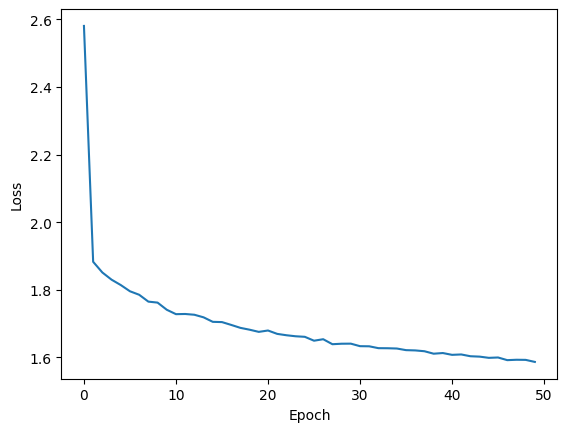

In [27]:
plt.plot(range(50), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Evaluate the trained network.

total = 0
correct = 0
with torch.no_grad():   # No need for keeping track of necessary changes to the gradient.
  for data in test_dl:
    X, y = data
    output = model(X)
    for idx, val in enumerate(output):
      if torch.argmax(val) == y[idx]:
        correct += 1
      total += 1
  print('Accuracy:', round((correct/total) * 100, 3), "%")